In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
import numpy as np
print(np.__version__)

1.23.5


# Human Activity Detection
My chosen topic revolves around the dynamic field of human activity recognition with smartphone. As HAR lies in a research domain dedicated to automatically identifying and classifying regular activities performed by individuals using time series data from sensors.

### Dataset Used
For HAR model tranning, [WISDM Smartphone and Smartwatch Activity and Biometrics](https://archive.ics.uci.edu/dataset/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset) Dataset is used. It includes data collected from 51 subjects, each of whom were asked to perform 18 tasks for 3 minutes each. Each subject had a smartwatch placed on his/her dominant hand and a smartphone in their pocket. For more info about [Dataset.](https://archive.ics.uci.edu/ml/machine-learning-databases/00507/WISDM-dataset-description.pdf)



#### To Run the Code
This code is done in google collaboration with the dataset are set from the google drive and for that dataset folder should be added in drive. Download the required file from shared folder of google drive.
[Google Driver Link.](https://drive.google.com/drive/folders/1CAQjvJ2zukBxjBeqDTR44upDFboYrBPb?usp=sharing)

Add the shared file to your google drive and mount the google drive in google collaboration.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Creating the directory of all the required files from the google drive.

In [ ]:
directory = '/content/drive/MyDrive/AI_CW_Folder/wisdm-dataset'
DATA_DIR = '/content/drive/MyDrive/AI_CW_Folder/wisdm-dataset/HARTrainData'
DATA_PATH = '/content/drive/MyDrive/AI_CW_Folder/wisdm-dataset/HARTrainData/HAR.csv'
RAW_DATA_DIR = '/content/drive/MyDrive/AI_CW_Folder/wisdm-dataset/raw/phone'

### Packages

Begin by importing all the packages i have need during this assignment.
1. **numpy** is the fundamental package for scientific computing with Python.
2. **matplotlib** is a library to plot graphs in Python.
3. **os** package provides a way to interact with the operating system, allowing you to perform tasks such as reading or writing to the file system.
4. **pandas** is a powerful data manipulation library. It provides data structures like DataFrame for efficient data analysis and manipulation.
5. **matplotlib** is a widely-used plotting library in Python. The pyplot module provides a MATLAB-like interface for creating various types of plots and charts, enabling effective data visualization.
6. **LabelEncoder** is part of the scikit-learn library and is used for encoding categorical labels into numerical values. It's commonly employed in machine learning workflows.
7. **MinMaxScaler** is another scikit-learn component, MinMaxScaler is a preprocessing technique for scaling numerical features to a specific range. It's often used to normalize data for machine learning models.
8. **tensorflow** is an open-source machine learning framework.
9. **metrics** module in scikit-learn provides various metrics for evaluating model performance, such as accuracy, precision, recall, etc.
10. **Seaborn** is a statistical data visualization library based on Matplotlib.


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import metrics
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, LSTM, Dense, TimeDistributed
from google.colab import files

Activity mapping based on the given documentation instruction.

In [ ]:
ACTIVITY_MAP = {
    'A' : 'walking',
    'B' : 'jogging',
    'C' : 'stairs',
    'D' : 'sitting',
    'E' : 'standing'
}

Function to read and process phone data

In [ ]:
def read_phone_data():
    # Check if the data file already exists
    if os.path.exists(DATA_PATH):
        return pd.read_csv(DATA_PATH)

    # Initialize an empty list to store DataFrames for each sensor
    sensor_dfs = []
    columns = ['subject', 'activity', 'timestamp']

    # Loop through accelerometer and gyroscope sensors
    for sensor in ['accel', 'gyro']:
        # Initialize a list to store file contents for the sensor
        sensor_files = []

        # Loop through files in the sensor directory
        for file_name in os.listdir(os.path.join(RAW_DATA_DIR, sensor)):
            if file_name.endswith('.txt'):
                file_path = os.path.join(RAW_DATA_DIR, sensor, file_name)

                # Read the content of the file and append to the list
                with open(file_path, 'r') as file:
                    content = file.read()
                    sensor_files.append(content)

        # Create a DataFrame for the sensor data
        df = pd.DataFrame([line.split(',') for file_content in sensor_files for line in file_content.split('\n')],
                          columns=columns + [sensor + '_' + axis for axis in 'xyz'])

        # Clean up the 'z' column by removing semicolons and converting to float
        df[sensor + '_z'] = df[sensor + '_z'].str.replace(';', '', regex=False).astype(float)

        # Filter rows based on valid activities from ACTIVITY_MAP
        df = df.loc[df['activity'].isin(ACTIVITY_MAP.keys())]

        # Map activity codes to human-readable names using ACTIVITY_MAP
        df['activity'] = df['activity'].map(ACTIVITY_MAP)

        # Append the sensor DataFrame to the list
        sensor_dfs.append(df)

    # Merge accelerometer and gyroscope DataFrames on common columns
    har_df = pd.merge(sensor_dfs[0], sensor_dfs[1], on=columns)

    # Drop rows with missing values
    har_df = har_df.dropna()

    # Drop duplicate rows
    har_df = har_df.drop_duplicates()

    # Create the data directory if it doesn't exist
    os.makedirs(DATA_DIR, exist_ok=True)

    # Save the final DataFrame to a CSV file
    har_df.to_csv(DATA_PATH, index=False)

    # Return the final DataFrame
    return har_df

Displaying the read data.

> Within the data file, each line is:

Subject-id, Activity Label, Timestamp, x, y, z

In [ ]:
har_df = read_phone_data()
display(har_df.head())
display(har_df.shape)

,subject,activity,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,1600,walking,252207918580802,-4.332779,13.361191,-0.718872,-0.853210,0.297226,0.890182
1,1600,walking,252207968934806,-0.319443,13.318359,-0.232025,-0.875137,0.015472,0.162231
2,1600,walking,252208019288809,1.566452,9.515274,-0.017776,-0.720169,0.388489,-0.284012
3,1600,walking,252208069642813,-0.323746,5.262665,0.322342,-0.571640,1.227402,-0.241669
4,1600,walking,252208119996817,-1.811676,3.710510,1.373932,-0.380493,1.202835,-0.213135


(758412, 9)

Info of the read data columns.

The features are defined as follows:


*   subject-id: Identfies the subject and is an integer value between 1600 and 1650.

*   activity-label: see activity_key.txt for a mapping from 18 characters to the
       activity name
* timestamp: time that the reading was taken (Unix Time)
* x: x sensor value (real valued)
* y: y sensor value (real valued)
* z: z sensor value (real valued)








In [ ]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758412 entries, 0 to 758411
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   subject    758412 non-null  int64  
 1   activity   758412 non-null  object 
 2   timestamp  758412 non-null  int64  
 3   accel_x    758412 non-null  float64
 4   accel_y    758412 non-null  float64
 5   accel_z    758412 non-null  float64
 6   gyro_x     758412 non-null  float64
 7   gyro_y     758412 non-null  float64
 8   gyro_z     758412 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 52.1+ MB


In [ ]:
# List of features for which descriptive statistics will be calculated
FEATURES = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
subset_df = har_df[FEATURES]

# The resulting DataFrame is rounded to 3 decimal places for readability
stats_df = subset_df.describe().loc[['count', 'mean', 'std', 'min', 'max']].round(3)
# Display the calculated statistics DataFrame
stats_df

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
count,758412.000,758412.000,758412.000,758412.000,758412.000,758412.000
mean,0.487,-1.521,-0.094,-0.008,-0.010,-0.005
std,5.738,8.505,4.856,1.276,1.507,1.035
min,-78.478,-77.635,-58.271,-24.771,-34.978,-34.985
max,77.479,37.884,42.222,23.529,31.623,13.166


Visualizing Sensor Data

In [ ]:
# Function to plot sensor readings for a specific subject, activity, and sensor
def plot_sensor_readings(sensor, subject, start=0, end=1024):
    # Loop through each activity in ACTIVITY_MAP
    for activity in ACTIVITY_MAP.values():
        # Query the DataFrame to get data for the specified subject and activity within the specified range
        data = har_df.query(f'subject == {subject} and activity == "{activity}"')[start:end]

        # If no data is found, skip to the next activity
        if len(data) == 0:
            continue

        # Create a subplot with three axes for X, Y, and Z axes
        fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20, 10), sharex=True)

        # Plot each axis using the plot_axis function
        plot_axis(ax0, data['timestamp'], data[sensor + '_x'], 'X-Axis')
        plot_axis(ax1, data['timestamp'], data[sensor + '_y'], 'Y-Axis')
        plot_axis(ax2, data['timestamp'], data[sensor + '_z'], 'Z-Axis')

        # Adjust subplot layout
        plt.subplots_adjust(hspace=0.2)

        # Set a title for the entire plot based on sensor and activity
        fig.suptitle(sensor.upper() + ' :: ' + activity.upper())

        # Adjust the layout to prevent title overlap
        plt.subplots_adjust(top=0.90)

        # Display the plot
        plt.show()

# Function to plot a single axis
def plot_axis(ax, x, y, title):
    # Plot the data on the specified axis
    ax.plot(x, y, 'r')

    # Set title and adjust display settings
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

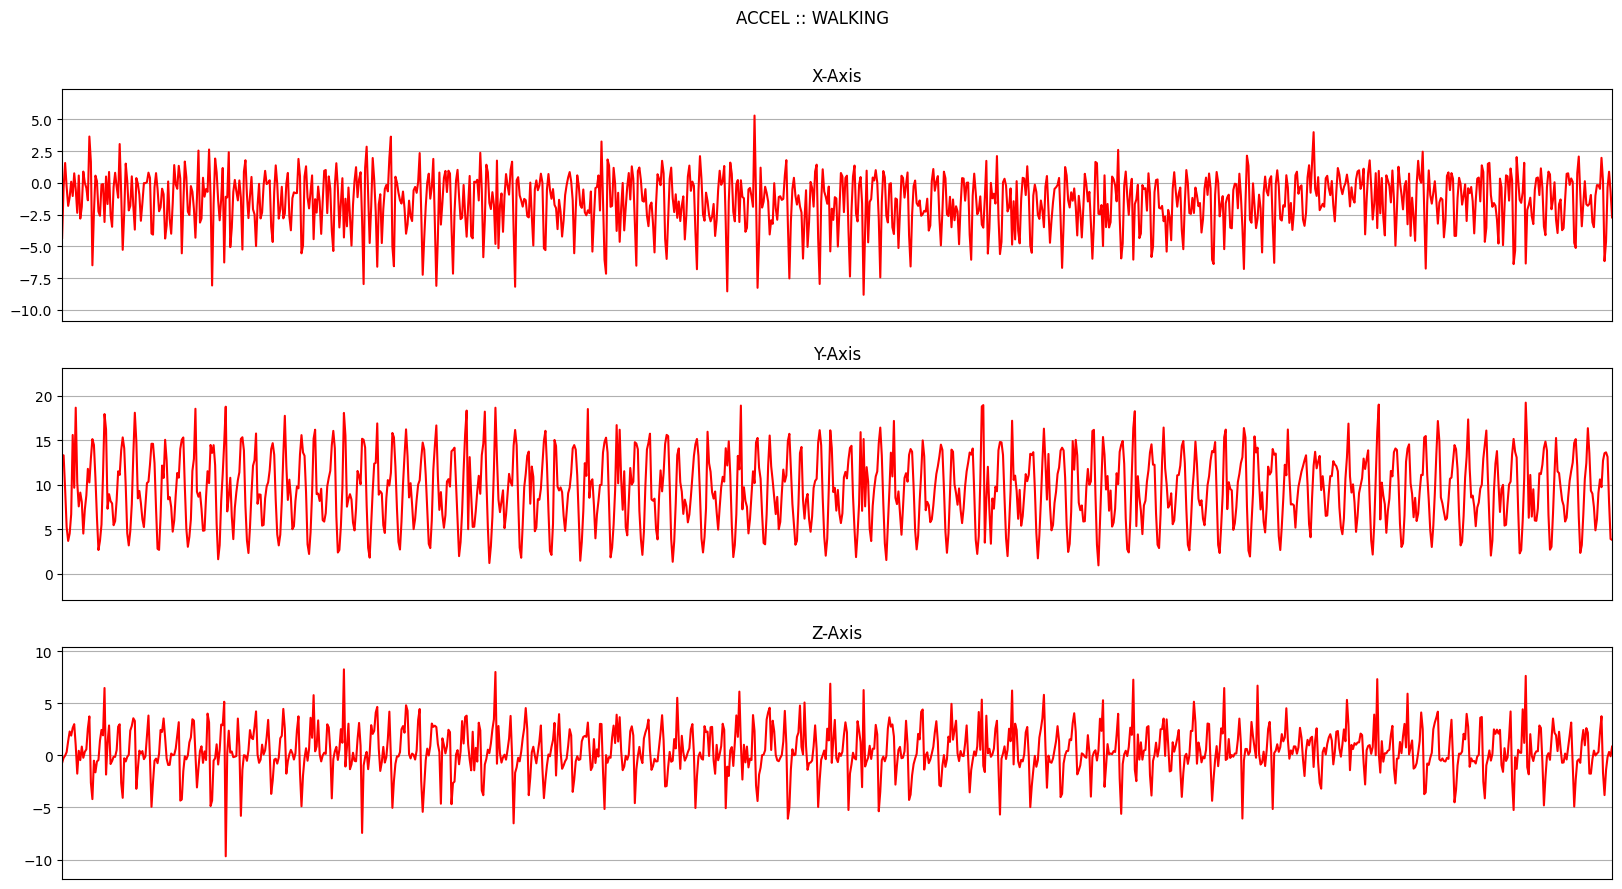

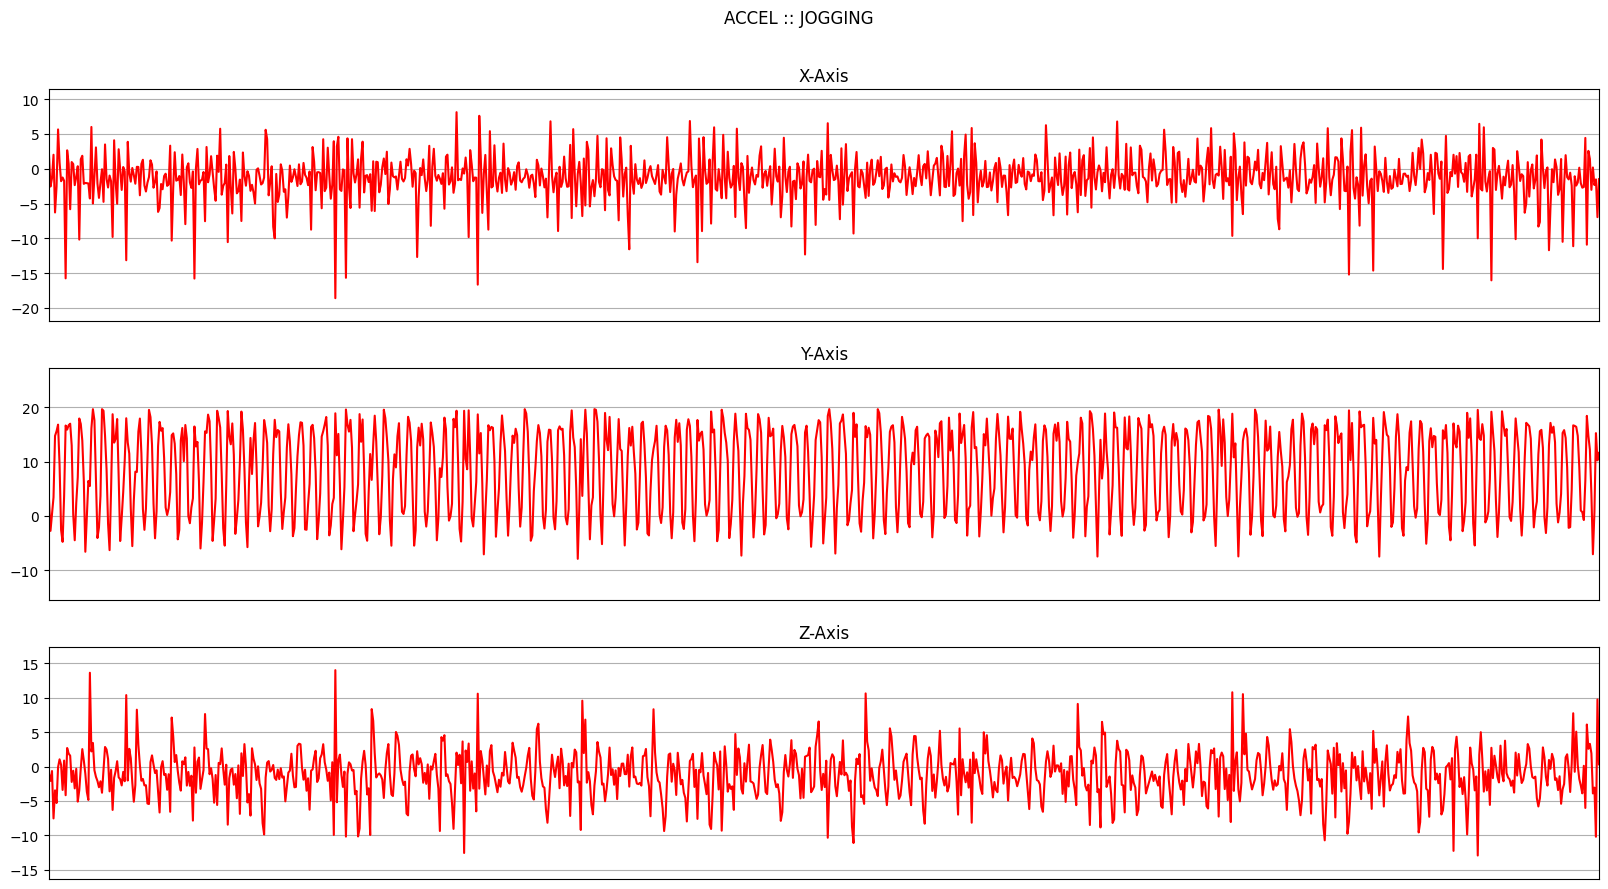

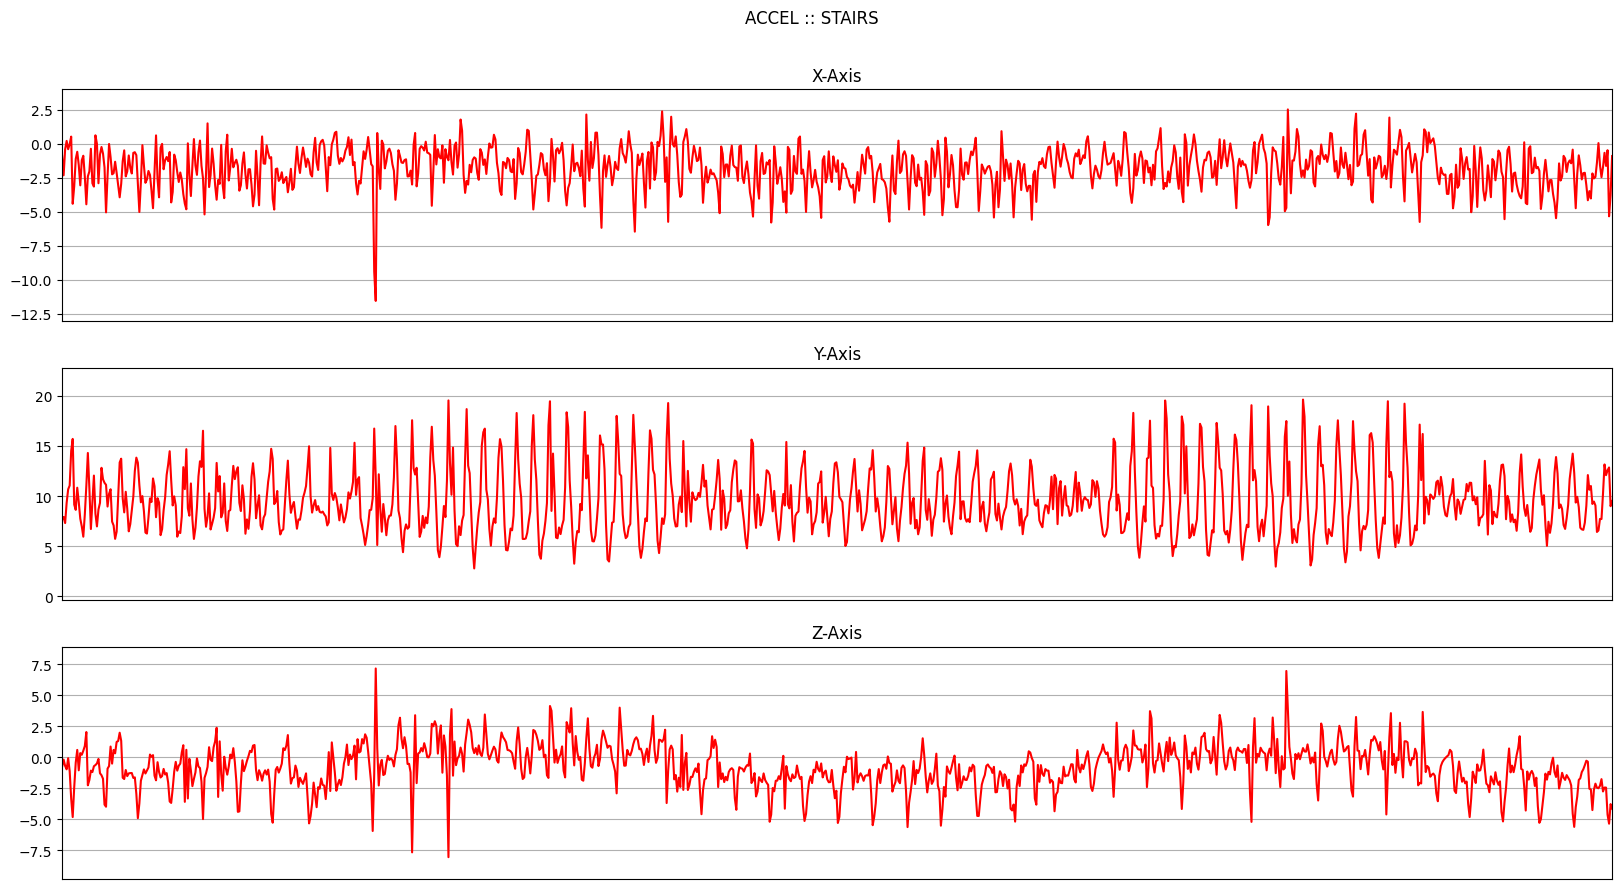

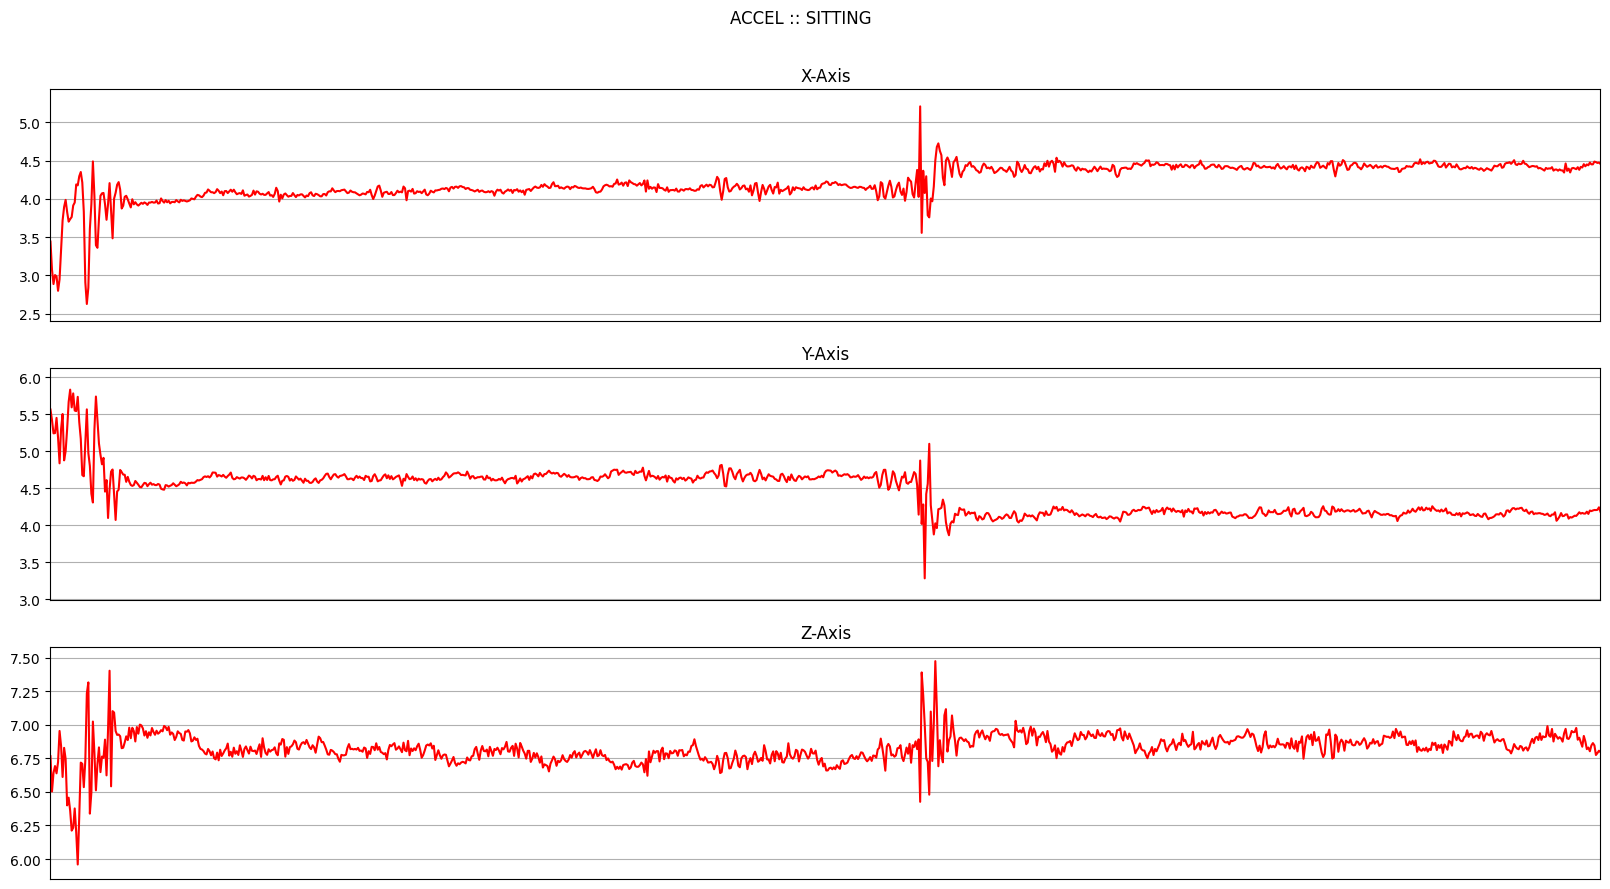

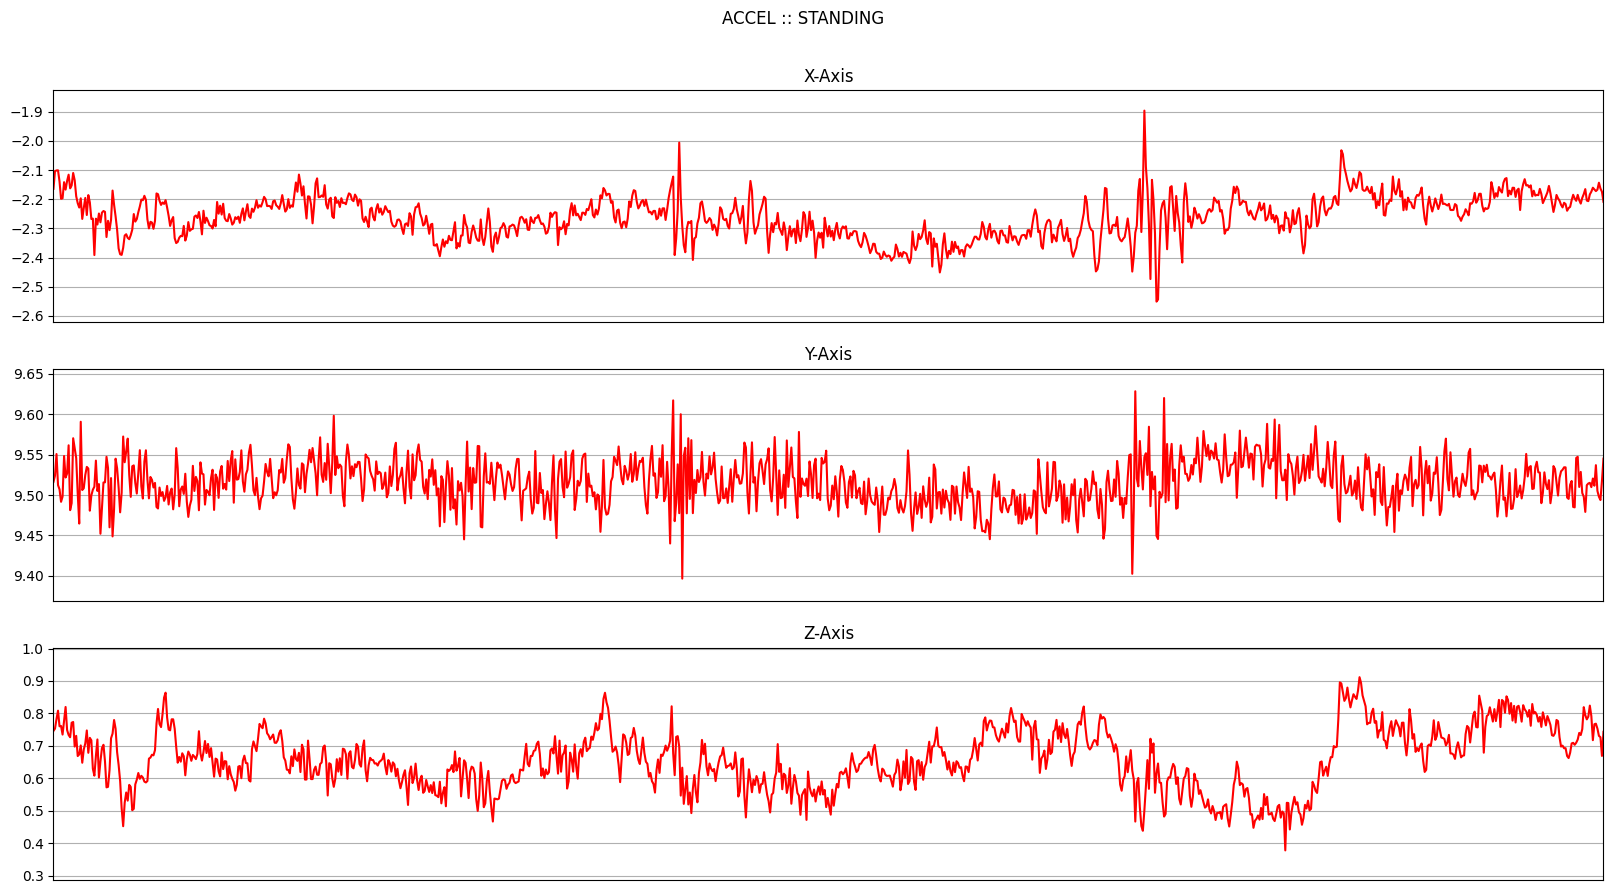

In [ ]:
plot_sensor_readings('accel', 1600)

Visualizing the total activities

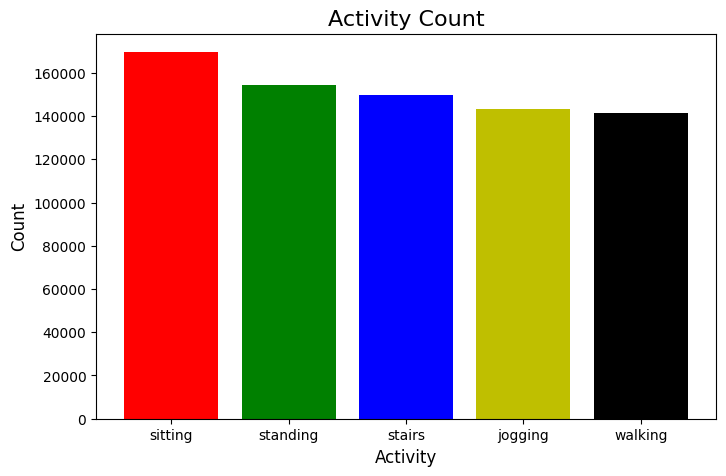

In [ ]:
# Count the occurrences of each activity in the DataFrame
activity_count = har_df.activity.value_counts()

# Create a figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot a bar chart with activity names on the x-axis and counts on the y-axis
# Assign different colors to each activity for better distinction
ax.bar(activity_count.index, activity_count.values, color=['r', 'g', 'b', 'y', 'k'])

# Set title and labels for better readability
ax.set_title('Activity Count', {'fontsize': 16})
ax.set_xlabel('Activity', {'fontsize': 12})
ax.set_ylabel('Count', {'fontsize': 12})

# Display the plot
plt.show()

Creating input column for training

In [ ]:
# Sequence length representing 3 seconds (20 samples per second * 3 seconds)
SEQ_LEN = 60

# List of sensor reading column names for accelerometer and gyroscope data
COLUMNS = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Number of dimensions, which is the length of the COLUMNS list
DIMS = len(COLUMNS)
print(DIMS)

6


Encoding the labels

In [ ]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the specified columns in the DataFrame
har_df[COLUMNS] = scaler.fit_transform(har_df[COLUMNS])

# Create a LabelEncoder object
encoder = LabelEncoder()

# Apply label encoding to the 'activity' column in the DataFrame
har_df['activity'] = encoder.fit_transform(har_df['activity'])

Setting the dimesion of the data.

In [ ]:
# Initialize empty lists to store input sequences (X) and labels (y)
X = []
y = []

# Iterate through grouped data based on subject and activity
for index, data in har_df.groupby(['subject', 'activity'], sort=False):
    # Extract the sensor readings for the specified columns
    data = data[COLUMNS].values

    # Extract the activity label from the index
    label = index[1]

    # Create overlapping sequences of length SEQ_LEN
    for i in range(0, len(data) - SEQ_LEN, SEQ_LEN):
        # Append the sequence (reshaped to (1, SEQ_LEN, DIMS)) to X
        X.append(np.expand_dims(data[i:i+SEQ_LEN], axis=0))

        # Append the corresponding label to y
        y.append(label)

X = np.concatenate(X)
y = np.asarray(y)

In [ ]:
# Split the data into training and testing sets
# X_train and y_train will contain 90% of the data, and X_test and y_test will contain 10%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=1)
print(X_train.shape)
print(X_test.shape)

(11276, 60, 6)
(1253, 60, 6)


Creating the model.

In [ ]:
# Define a Sequential model
model = tf.keras.models.Sequential([
    # 1D Convolutional layer with 32 filters and kernel size 3
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, input_shape=(SEQ_LEN, DIMS)),

    # Long Short-Term Memory (LSTM) layer with 32 units
    tf.keras.layers.LSTM(units=32),

    # Dense layer with 64 units and ReLU activation function
    tf.keras.layers.Dense(units=64, activation='relu'),

    # Dropout layer with dropout rate of 0.2 to prevent overfitting
    tf.keras.layers.Dropout(0.2),

    # Output Dense layer with 5 units (for 5 classes) and softmax activation function
    tf.keras.layers.Dense(units=5, activation='softmax')
])

# Compile the model with sparse categorical crossentropy loss and accuracy metric
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 32)            608       
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 11,365
Trainable params: 11,365
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model to the training data
# The training history is stored in the 'history' variable
history = model.fit(
    X_train,             # Training sequences
    y_train,             # Training labels
    batch_size=50,       # Batch size for each training update
    epochs=100,          # Number of training epochs
    validation_data=(X_test, y_test),  # Validation data
    verbose=1            # Verbosity level (1 for progress bar, 0 for silent)
)

Epoch 1/100
226/226 [==============================] - 26s 93ms/step - loss: 1.6099 - accuracy: 0.2240 - val_loss: 1.6089 - val_accuracy: 0.2075
Epoch 2/100
226/226 [==============================] - 13s 58ms/step - loss: 1.6087 - accuracy: 0.2237 - val_loss: 1.6095 - val_accuracy: 0.2075
Epoch 3/100
226/226 [==============================] - 8s 37ms/step - loss: 1.6077 - accuracy: 0.2215 - val_loss: 1.6092 - val_accuracy: 0.2075
Epoch 4/100
226/226 [==============================] - 10s 42ms/step - loss: 1.6065 - accuracy: 0.2283 - val_loss: 1.6076 - val_accuracy: 0.2075
Epoch 5/100
226/226 [==============================] - 8s 35ms/step - loss: 1.5860 - accuracy: 0.2868 - val_loss: 1.6306 - val_accuracy: 0.1341
Epoch 6/100
226/226 [==============================] - 10s 42ms/step - loss: 1.5411 - accuracy: 0.3209 - val_loss: 1.4716 - val_accuracy: 0.3520
Epoch 7/100
226/226 [==============================] - 10s 43ms/step - loss: 1.4945 - accuracy: 0.3366 - val_loss: 1.4627 - val_accu

In [ ]:
model.evaluate(X_train, y_train)

353/353 [==============================] - 4s 11ms/step - loss: 0.2974 - accuracy: 0.8947


[0.29744383692741394, 0.8947321772575378]

In [ ]:
model.evaluate(X_test, y_test)

40/40 [==============================] - 1s 14ms/step - loss: 0.3713 - accuracy: 0.8731


[0.37130656838417053, 0.8731045722961426]

Validation of train and test set.

In [ ]:
def plot_learningCurve(history, epochs):
    # Create a range of epochs for the x-axis
    epoch_range = range(1, epochs + 1)

    # Plot training and validation accuracy
    plt.plot(epoch_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epoch_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training and validation loss
    plt.plot(epoch_range, history.history['loss'], label='Training Loss')
    plt.plot(epoch_range, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()

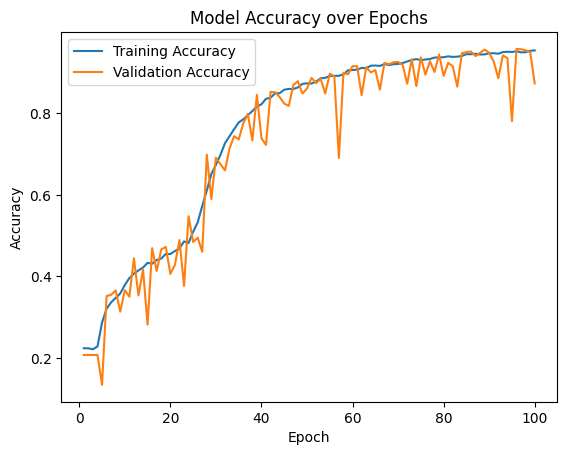

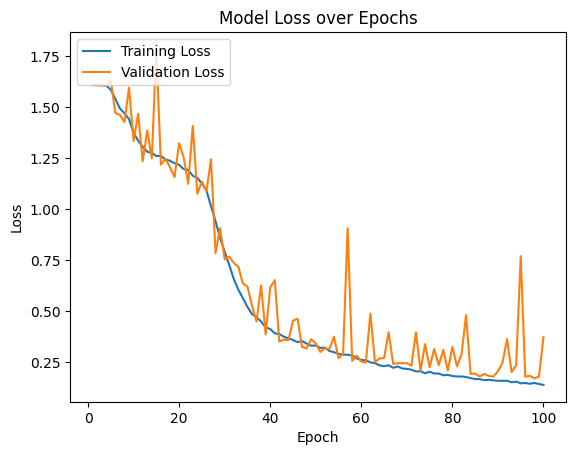

In [ ]:
plot_learningCurve(history,100)

40/40 [==============================] - 1s 11ms/step


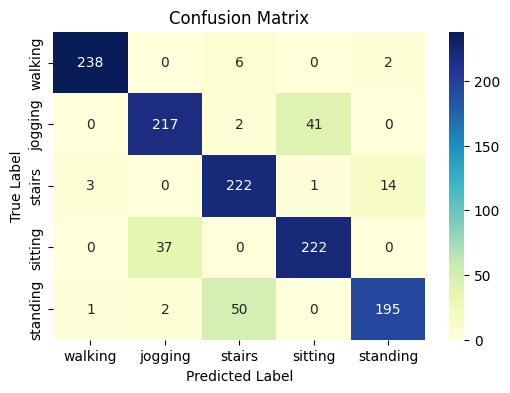

In [ ]:
# List of activity labels
LABELS = ['walking', 'jogging', 'stairs', 'sitting', 'standing']

# Make predictions on the test data
y_pred = model.predict(X_test)

# Extract the predicted classes (indices of the maximum values in each prediction vector)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
matrix = metrics.confusion_matrix(y_test, y_pred_classes)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Saving the model.

In [ ]:
model.save('HAR_model.keras')
files.download('HAR_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
new_model = tf.keras.models.load_model('HAR_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 32)            608       
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 11,365
Trainable params: 11,365
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils import to_categorical

# Assuming X_train and X_test are your input sequences
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

y_train_encoded = to_categorical(y_train, num_classes=5)
y_test_encoded = to_categorical(y_test, num_classes=5)

Denser Model

In [ ]:
# Define a Sequential model with a combination of Convolutional and Recurrent layers
model = Sequential([
    # TimeDistributed 1D Convolutional layer with 128 filters and kernel size 3, with ReLU activation
    TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(1, 60, 6)),

    # TimeDistributed MaxPooling layer with pool size 2
    TimeDistributed(MaxPooling1D(pool_size=2)),

    # TimeDistributed 1D Convolutional layer with 128 filters and kernel size 3, with ReLU activation
    TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')),

    # TimeDistributed Dropout layer with dropout rate of 0.5 to prevent overfitting
    TimeDistributed(Dropout(0.5)),

    # TimeDistributed MaxPooling layer with pool size 2
    TimeDistributed(MaxPooling1D(pool_size=2)),

    # TimeDistributed Flatten layer to flatten the output for the LSTM layer
    TimeDistributed(Flatten()),

    # Long Short-Term Memory (LSTM) layer with 100 units
    LSTM(100),

    # Dropout layer with dropout rate of 0.5 to prevent overfitting
    Dropout(0.5),

    # Dense layer with 100 units and ReLU activation function
    Dense(100, activation='relu'),

    # Output Dense layer with 5 units (for 5 classes) and softmax activation function
    Dense(5, activation='softmax')
])

# Compile the model with categorical crossentropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display a summary of the model architecture
model.summary()

In [ ]:
For F1 Score

f1_score_metric = F1Score(num_classes=5, average='micro')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score_metric])

In [ ]:
history = model.fit(
    X_train_reshaped,
    y_train_encoded,
    batch_size=50,
    epochs=100,
    validation_data=(X_test_reshaped, y_test_encoded),
    verbose=1
)

In [ ]:
model.evaluate(X_train_reshaped, y_train_encoded)

In [ ]:
model.evaluate(X_test_reshaped, y_test_encoded)

Increase over 3% of model accuracy and have low bias and variance.

In [ ]:
# plot_learningCurve(history,100)

In [ ]:
model.save('Heavy_HAR_model.keras')
files.download('Heavy_HAR_model.keras')

In [ ]:
heavy_new_model = tf.keras.models.load_model(model)

# Show the model architecture
heavy_new_model.summary()

Creating Prediction function.

In [ ]:
def predict_activity(model, sample_data):
    # Use the provided model to make predictions on the sample data
    predictions = model.predict(sample_data)

    # List of activity labels
    LABELS = ['walking', 'jogging', 'stairs', 'sitting', 'standing']

    # Get the predicted label based on the class with the highest probability
    predicted_label = LABELS[np.argmax(predictions)]

    return predicted_label

In [ ]:
# sample_data = np.random.rand(1, 60, 6)
# predicted_label = predict_activity(new_model, sample_data)
# print("Predicted Activity:", predicted_label)

1/1 [==============================] - 1s 676ms/step
Predicted Activity: walking


In [ ]:
from google.colab import files
import tensorflow as tf

# Upload the file
uploaded = files.upload()

# Get the filename
filename = next(iter(uploaded))

# Load the model
loaded_model = tf.keras.models.load_model(filename)

# Check model summary
loaded_model.summary()

Saving HAR_model.keras to HAR_model.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 32)            608       
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 11,365
Trainable params: 11,365
Non-trainable params: 0
_________________________________________________________________
